### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 50)

### Global & Functions

In [3]:
df = pd.DataFrame()

In [4]:
def checkData(x):
    print(f"\nInfo dos valores:\n")
    print(x.info())
    print(f"\nDescrição dos dados:\n\n{x.describe()}")
    print(f"\nNúmero de nulos por coluna:\n\n{x.isnull().sum()}")
    print(f"\nTipos das colunas:\n\n{x.dtypes}")
    return

def checkCorrelation(x):
    plt.figure(figsize=(10,8))
    sns.heatmap(x.select_dtypes(include=[np.number]).corr(), annot=True)
    plt.show()
    return

def checkOutliers(x):
    """This functions receives a DataFrame and returns a DataFrame with the outliers.
    It takes as premise that the data is normally distributed."""
    dfOutliers  = pd.DataFrame()
    # Itera sobre as colunas númericas
    for column in x.select_dtypes(include=[np.number]).columns:
        # Calcula o 1 quartil (Q1)
        Q1 = x[column].quantile(0.25)
        # Calcula o 3 quartil (Q3)
        Q3 = x[column].quantile(0.75)
        # Calcula o Intervalo Interquartil (IQR)
        IQR = Q3 - Q1
        # Define os limites inferior e superior para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Identica os outliers da coluna atual e adiciona ao DataFrame de outliers
        outliers = x[(x[column] < lower_bound) | (x[column] > upper_bound)]
        # Concatene os outliers da coluna atual ao DataFrame de outliers
        dfOutliers = pd.concat([df, outliers])
    outliersData = df.drop_duplicates().reset_index(drop=True)
    return outliersData

def checkHist(x):
    """This function receives a DataFrame and returns a histogram of the data."""
    x.hist(bins=50, figsize=(25,10))
    plt.show()
    return

### Loading data

In [5]:
df_author    = pd.read_csv('dataset/author.csv')
df_award     = pd.read_csv('dataset/award.csv')
df_book      = pd.read_csv('dataset/book.csv')
df_edition   = pd.read_csv('dataset/edition.csv')
df_format    = pd.read_csv('dataset/format.csv')
df_genders   = pd.read_csv('dataset/genders.csv')
df_info      = pd.read_csv('dataset/info.csv')
df_publisher = pd.read_csv('dataset/publisher.csv')
df_ratings   = pd.read_csv('dataset/ratings.csv')
df_sales     = pd.read_csv('dataset/sales.csv')
df_series    = pd.read_csv('dataset/series.csv')

### Cleaning, Transformation and Feature Enginnering

In [6]:
cols_new = ['book_id', 'title', 'award_name', 'year_won']
df_award.columns = cols_new
df = pd.merge(df_book, df_author, how='left', on='author_id')
df = pd.merge(df, df_award, how='left', on='book_id')
df = pd.merge(df, df_edition, how='left', on='book_id')
df = pd.merge(df, df_format, how='left', on='format_id')
df = pd.merge(df, df_info, how='left', on='book_id')
df = pd.merge(df, df_genders, how='left', on='genre_id')
df_publisher.drop_duplicates(inplace=True)
df = pd.merge(df, df_publisher, how='left', on='book_id')
df = pd.merge(df, df_series, how='left', on='series_id')
df = pd.merge(df, df_sales, how='left', on='isbn')
rating_stats = df_ratings.groupby('book_id').agg(
    rating_mean=('rating', 'mean'),
    review_count=('rating', 'count')
).reset_index()
df = pd.merge(df, rating_stats, how='left', on='book_id')
df.drop(columns=['title_y', 'pub_id_x', 'genre_id', 'series_id',
                 'format_id','isbn' ], inplace=True)
df.rename(columns={'title_x': 'title', 'pub_id_y': 'publisher_id',
                   'name':'pub_name', 'city':'pub_city', 'state':'pub_state',
                   'country':'pub_country', 'rating_x':'rating_mean',
                   'rating_y':'rating_count', 'genre_desc':'genre',
                   'format_desc':'format'}, inplace=True)
df['author_name'] = df['first_name'] + ' ' + df['last_name']
df.drop(columns=['first_name', 'last_name'], inplace=True)

In [7]:
# Vamos dropar a linha que não possuem publisher nem sale_date
df.dropna(subset=['publisher_id'], inplace=True)
# Vamos dropar as linhas do livro Cimornul (CC830) que não tem dados de venda
df.dropna(subset=['sale_date'], inplace=True)
# Vamos dropar a linha que não possuem publisher nem sale_date
df.dropna(subset=['publisher_id'], inplace=True)
# Vamos dropar as linhas do livro Cimornul (CC830) que não tem dados de venda
df.dropna(subset=['sale_date'], inplace=True)
# Preencher campos com desconto zero
df['discount'].fillna(0, inplace=True)
# Preencher volume do livro como zero, para aqueles que não possuem continuação
df['volume_number'].fillna(0, inplace=True)
# object to datetime
df['birthday'] = pd.to_datetime(df['birthday'])
df['publication_date'] = pd.to_datetime(df['publication_date'])
df['sale_date'] = pd.to_datetime(df['sale_date'], format='%d/%m/%Y')
# float to int
df['year_won'] = df['year_won'].astype('Int64')
df['pages'] = df['pages'].astype('Int64')
df['print_run_size_k'] = df['print_run_size_k'].astype('Int64')
df['volume_number'] = df['volume_number'].astype('Int64')
df['year_established'] = df['year_established'].astype('Int64')
df['review_count'] = df['review_count'].astype('Int64')
# object to float
df['discount'].replace(',', '.', regex=True, inplace=True)
df['discount'] = df['discount'].astype('float64')

df.shape

/tmp/ipykernel_51527/1415932165.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['discount'].fillna(0, inplace=True)
/tmp/ipykernel_51527/1415932165.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

(67923, 30)

In [8]:
df.sample(5)

,book_id,title,author_id,birthday,country_residence,hrs_writing_day,award_name,year_won,publication_date,pages,print_run_size_k,price,format,volume_number,genre,pub_name,pub_city,pub_state,pub_country,year_established,marketing_spend,publisher_id,series_name,sale_date,discount,item_id,order_id,rating_mean,review_count,author_name
19926,HP265,Heliotrope Pajamas,MW974,2141-01-31,Hong Kong,6.0,Newberry Medal,2182,2188-06-03,16,55,5.99,Board book,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,2193-12-24,0.0,107376-61-3114,107376-49073,4.543651,1764,Malin Wolff
52695,TM925,The Mallemaroking,BT132,2150-01-28,United States,5.0,Nebula Award,2179,2183-02-25,819,25,21.50,Hardcover,1,SciFi/Fantasy,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,The Mallemaroking Saga,2193-04-13,0.0,107121-18-5406,107121-8333,4.659653,1901,Bianca Thompson
4000,AM124,A Horrible Human with the Habits of a Monster,KD840,2163-09-24,South Africa,3.0,NaN,<NA>,2189-03-24,85,3,23.99,Graphic,0,Fiction,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,2193-07-13,0.0,107212-56-3796,107212-21505,3.714754,305,Kenneth Douglas
21721,LB510,Lace and Brandy,LD375,2155-08-19,New Zealand,8.0,NaN,<NA>,2186-07-25,380,25,9.50,Mass market paperback,5,Romance,Sound & Seas Co.,Dunedin,Otago,New Zealand,1973,151000.0,SSC,Esme s Ladies,2193-10-13,0.0,107304-37-9853,107304-39613,4.453271,1284,Lynne Danticat
38043,SS361,Some Eggs or Something?,LK915,2147-03-27,China,6.0,NaN,<NA>,2181-07-03,105,20,12.50,Trade paperback,0,Fiction,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,2193-02-23,0.0,107072-45-1990,107072-3700,3.894207,794,Lori Kaan


### Descrição

In [9]:
checkData(df)


Info dos valores:

<class 'pandas.core.frame.DataFrame'>
Index: 67923 entries, 0 to 67925
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   book_id            67923 non-null  object        
 1   title              67923 non-null  object        
 2   author_id          67923 non-null  object        
 3   birthday           67923 non-null  datetime64[ns]
 4   country_residence  67923 non-null  object        
 5   hrs_writing_day    67923 non-null  float64       
 6   award_name         33906 non-null  object        
 7   year_won           33906 non-null  Int64         
 8   publication_date   67923 non-null  datetime64[ns]
 9   pages              67923 non-null  Int64         
 10  print_run_size_k   67923 non-null  Int64         
 11  price              67923 non-null  float64       
 12  format             67923 non-null  object        
 13  volume_number      67923 non-null  Int64      

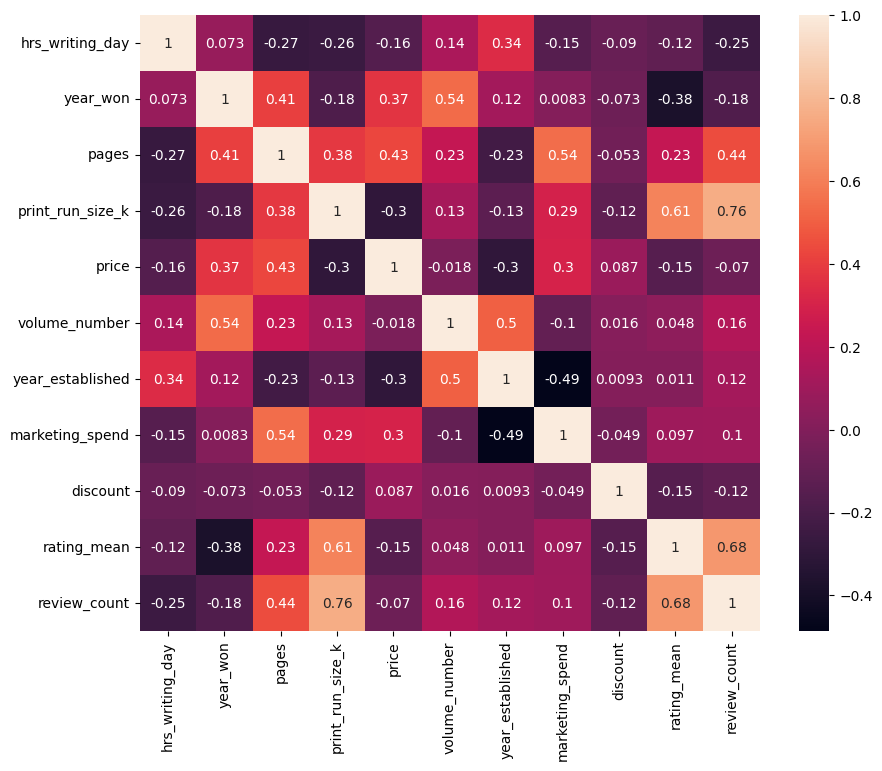

In [10]:
checkCorrelation(df)

In [11]:
checkOutliers(df)

,book_id,title,author_id,birthday,country_residence,hrs_writing_day,award_name,year_won,publication_date,pages,print_run_size_k,price,format,volume_number,genre,pub_name,pub_city,pub_state,pub_country,year_established,marketing_spend,publisher_id,series_name,sale_date,discount,item_id,order_id,rating_mean,review_count,author_name
0,AD222,Alanna Saves the Day,BH149,2122-11-27,United States,1.0,Caldecott Medal,2186,2185-09-22,188,10,8.99,Trade paperback,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,2193-01-02,0.0,107020-1-850,107020-2,4.018008,944,Bernard Hopf
1,AD222,Alanna Saves the Day,BH149,2122-11-27,United States,1.0,Caldecott Medal,2186,2185-09-22,188,10,8.99,Trade paperback,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,2193-01-02,0.0,107020-4-9809,107020-4,4.018008,944,Bernard Hopf
2,AD222,Alanna Saves the Day,BH149,2122-11-27,United States,1.0,Caldecott Medal,2186,2185-09-22,188,10,8.99,Trade paperback,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,2193-01-02,0.0,107020-41-7081,107020-43,4.018008,944,Bernard Hopf
3,AD222,Alanna Saves the Day,BH149,2122-11-27,United States,1.0,Caldecott Medal,2186,2185-09-22,188,10,8.99,Trade paperback,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,2193-01-02,0.0,107020-94-1392,107020-44,4.018008,944,Bernard Hopf
4,AD222,Alanna Saves the Day,BH149,2122-11-27,United States,1.0,Caldecott Medal,2186,2185-09-22,188,10,8.99,Trade paperback,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,2193-01-02,0.0,107020-14-6317,107020-5,4.018008,944,Bernard Hopf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67918,ZT703,Zero over Twelve,BM856,2145-01-18,Brazil,6.0,NaN,<NA>,2187-11-20,338,26,8.99,Mass market paperback,0,Mystery,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,2193-12-29,0.0,107381-20-3840,107381-49614,3.986920,841,Burton Malamud
67919,ZT703,Zero over Twelve,BM856,2145-01-18,Brazil,6.0,NaN,<NA>,2187-11-20,338,26,8.99,Mass market paperback,0,Mystery,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,2193-12-30,0.0,107382-6-7793,107382-49692,3.986920,841,Burton Malamud
67920,ZT703,Zero over Twelve,BM856,2145-01-18,Brazil,6.0,NaN,<NA>,2187-11-20,338,26,8.99,Mass market paperback,0,Mystery,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,2193-12-30,0.0,107382-19-6522,107382-49693,3.986920,841,Burton Malamud
67921,ZT703,Zero over Twelve,BM856,2145-01-18,Brazil,6.0,NaN,<NA>,2187-11-20,338,26,8.99,Mass market paperback,0,Mystery,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,2193-12-30,0.0,107382-12-1851,107382-49694,3.986920,841,Burton Malamud


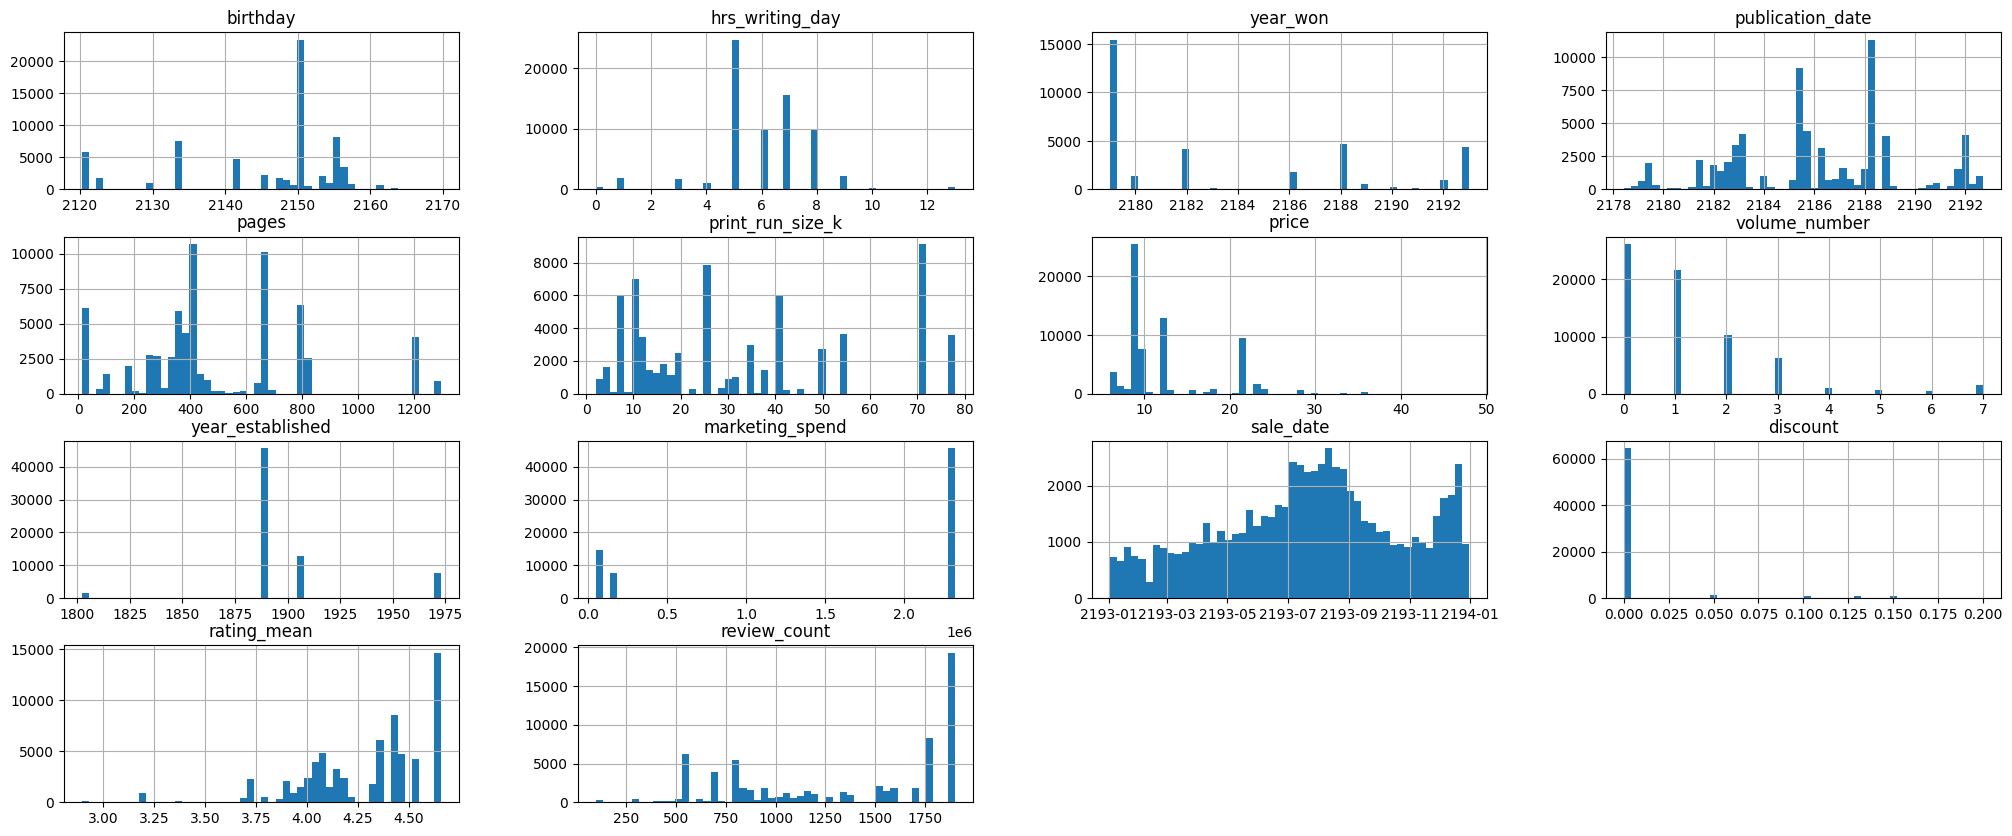

In [12]:
checkHist(df)

### Conclusões

##### Livros melhores avaliados vendem mais?
    - Lorem ipsum dolor sit amet, consectetur adipiscing elit.

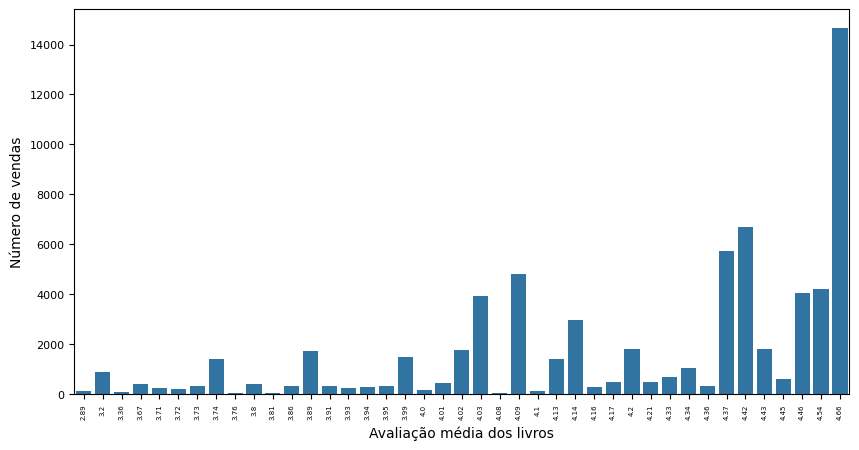

In [13]:
aux = df[['book_id', 'rating_mean']].groupby('book_id').mean().round(2)
aux1 = df[['book_id', 'order_id']].groupby('book_id').count()
a = pd.merge(aux, aux1, how='left', on='book_id').sort_values(by='rating_mean', ascending=False)
b = a.groupby('rating_mean').sum().reset_index()

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 8
plt.xticks(rotation=90)
ax = sns.barplot(data=b, x='rating_mean', y='order_id');
ax.set(xlabel='Avaliação média dos livros', ylabel='Número de vendas');

##### Quantidade de avaliações influenciam na venda?
    - Lorem ipsum dolor sit amet, consectetur adipiscing elit.

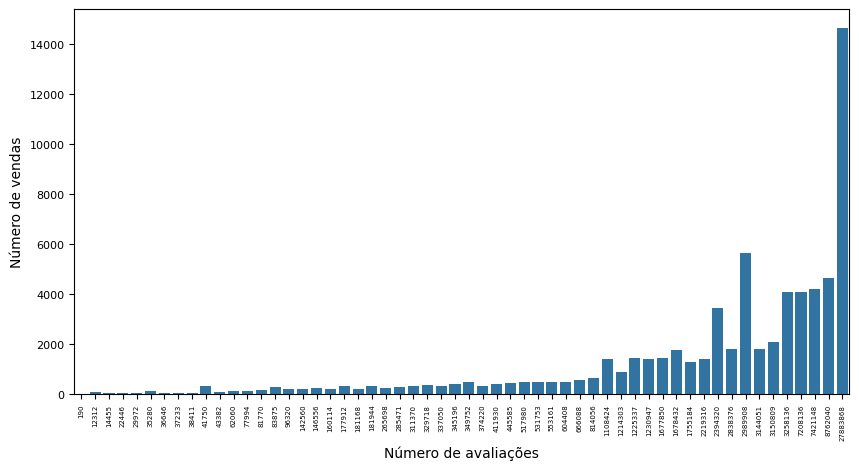

In [14]:
aux = df[['book_id', 'review_count']].groupby('book_id').sum()
aux1 = df[['book_id', 'order_id']].groupby('book_id').count()
a = pd.merge(aux, aux1, how='left', on='book_id')
b = a.groupby('review_count').sum().reset_index()

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 8
plt.xticks(rotation=90)
ax = sns.barplot(data=b, x='review_count', y='order_id');
ax.set(xlabel='Número de avaliações', ylabel='Número de vendas');

##### Editoras mais antigas vendem mais?
    - Lorem ipsum dolor sit amet, consectetur adipiscing elit.

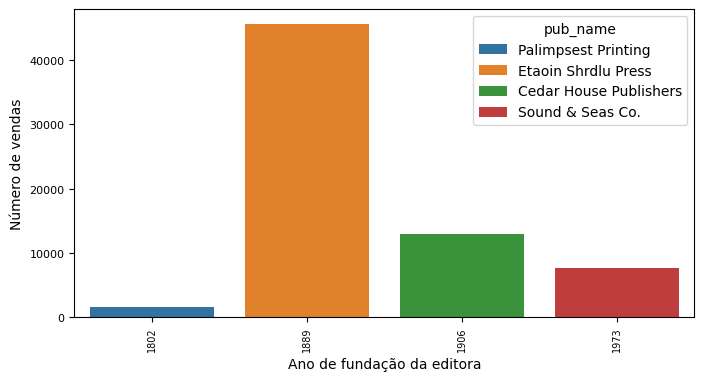

In [15]:
plt.figure(figsize=(8, 4));
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 8
plt.xticks(rotation=90)
ax = sns.countplot(data=df, x='year_established', hue='pub_name');
ax.set(xlabel='Ano de fundação da editora', ylabel='Número de vendas');

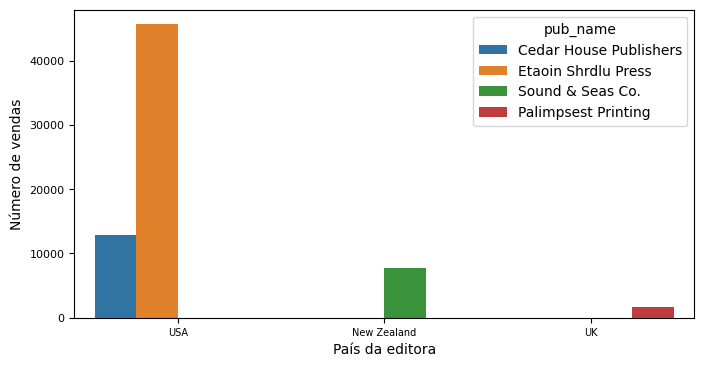

In [16]:
plt.figure(figsize=(8, 4));
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 8
ax = sns.countplot(data=df, x='pub_country', hue='pub_name');
ax.set(xlabel='País da editora', ylabel='Número de vendas');

##### Autores com mais horas por dia de escrita vendem mais livros?
    - Verdadeiro, pois...

In [17]:
# Quantidade de horas escritas por autor
hrs_per_author = df[['author_name', 'hrs_writing_day']].groupby('author_name').sum().reset_index().sort_values('hrs_writing_day', ascending=False)

# Quantidade de vendas por autor
sales_per_author = df[['author_name', 'item_id']].groupby('author_name').count().reset_index().sort_values('item_id', ascending=False)

# Merge das duas tabelas
author_hrs_sales = pd.merge(hrs_per_author, sales_per_author, how='left', on='author_name')
author_hrs_sales.head()

,author_name,hrs_writing_day,item_id
0,Bianca Thompson,116905.0,23381
1,Lynne Danticat,64296.0,8037
2,Carolyn Segal,52836.0,7548
3,Charles Fenimore,40754.0,5822
4,Malin Wolff,28152.0,4692


Text(0.5, 1.0, 'Hours Writing Day vs Number of Sales')

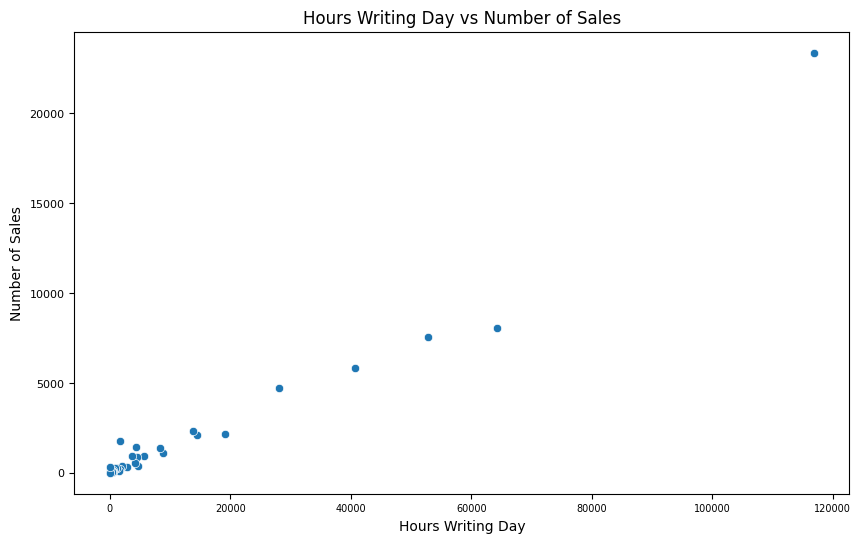

In [18]:
# Mostrar o gráfico de horas escritas por dia x número de vendas
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hrs_writing_day', y='item_id', data=author_hrs_sales)
plt.xlabel('Hours Writing Day')
plt.ylabel('Number of Sales')
plt.title('Hours Writing Day vs Number of Sales')

##### Autores britanicos vendem mais livros?
    - Falso, os americanos vendem mais, como pode ser visto no gráfico abaixo.

   country_residence  books_sold
11     United States       34010
6        New Zealand       10744
7             Norway        6835
4          Hong Kong        6172
0             Brazil        4904
10    United Kingdom        2483
2              China        1455
1             Canada         577
9       South Africa         275
5        Netherlands         266
8          Singapore         126
3            Germany          76


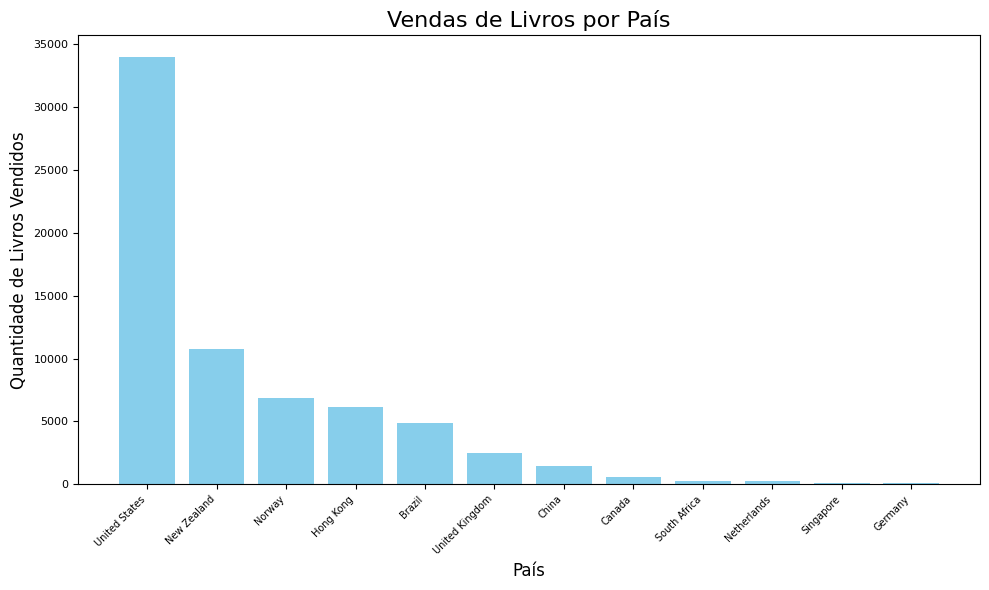

In [19]:
# Lista de nacionalidades
nacionalidades = [
    'United States', 'Brazil', 'South Africa', 'Norway', 'New Zealand',
    'Hong Kong', 'China', 'Netherlands', 'United Kingdom', 'Canada',
    'Germany', 'Singapore'
]

# Filtrar os dados com base nas nacionalidades e contar vendas
sales_by_country = (df[df['country_residence'].isin(nacionalidades)]
                    .groupby('country_residence')['item_id'].count()
                    .reset_index().rename(columns={'item_id': 'books_sold'})
                    .sort_values(by='books_sold', ascending=False))

# Exibir a tabela
print(sales_by_country)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.bar(sales_by_country['country_residence'], sales_by_country['books_sold'], color='skyblue')
plt.title('Vendas de Livros por País', fontsize=16)
plt.xlabel('País', fontsize=12)
plt.ylabel('Quantidade de Livros Vendidos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Autores mais velhos vendem mais livros?
    **Séria bom explicar a escala dessa idade no gráfico ou normalizar**
    - Falso, não foi notado nenhuma correlação entre vendas e idade dos autores.
    

    relative_age  books_sold
0              0        5822
1            984        1778
2           3402         942
3           3660          59
4           4938        7548
5           7624        4692
6           8536          59
7           9072        2309
8           9536         126
9           9870        1396
10          9966          71
11         10059         342
12         10222        1433
13         10262          58
14         10737         293
15         10748         116
16         10753         261
17         10908       23381
18         11279          76
19         11338         518
20         12256        2077
21         12407         930
22         12937        8037
23         12947         208
24         13127        2131
25         13238         215
26         13334        1103
27         13459           2
28         13494         887
29         14848         362
30         14996         353
31         15895         275
32         18092          63


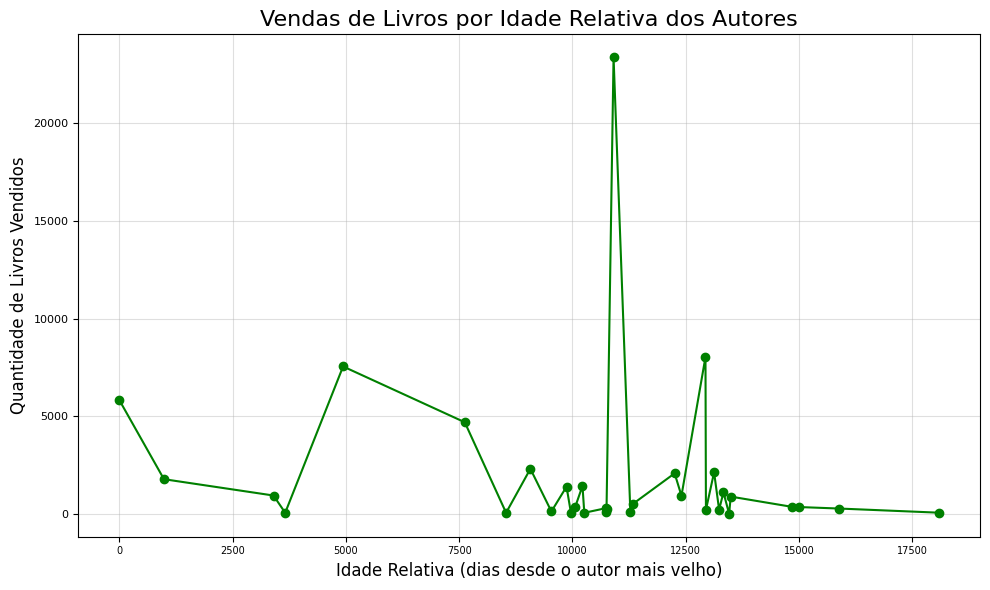

In [20]:
# Calcular a idade relativa (autor mais velho como referência)
oldest_birthday = df['birthday'].min()  # Data de nascimento mais antiga
df['relative_age'] = (df['birthday'] - oldest_birthday).dt.days

# Agrupar por idade relativa e contar as vendas
sales_by_age = (df.groupby('relative_age')['item_id'].count().reset_index()
                .rename(columns={'item_id': 'books_sold'})
                .sort_values(by='relative_age', ascending=True)  # Ordenar do mais velho para o mais novo
)

# Exibir a tabela
print(sales_by_age)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(sales_by_age['relative_age'], sales_by_age['books_sold'], marker='o', linestyle='-', color='green')
plt.title('Vendas de Livros por Idade Relativa dos Autores', fontsize=16)
plt.xlabel('Idade Relativa (dias desde o autor mais velho)', fontsize=12)
plt.ylabel('Quantidade de Livros Vendidos', fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

##### Autores com mais livros lançados vendem mais?
    **Observações: aqui acho que vale a pena tentar normalizar os dados das vendas, pois do jeito que está sendo feito, pode haver uma distorção dos resultados. Por exemplo, autor1 lança 1 livro e tem 20 vendas, e autor2 lança 5 livros e tem 50 vendas, o autor 1 pode ter vendido menor número de copias, mas ele tem uma porcentagem melhor de "aproveitamento" do que o autor 2. Então talvez seja interessante normalizar as vendas pelo número de livros lançados para ver se a correlação ainda é verdadeira.**
    - Verdadeiro. Há uma correlação positiva entre a quantidade de livros lançados por um autor e as vendas desses livros.
    - Tirando um "outlier" de 8 livros lançados, há uma tendencia de crescimento.

            author_name  total_books  total_sales
23       Lynne Danticat            8         8037
10        Elmer Komroff            3          942
4        Burton Malamud            3         2309
11         Gloria Green            3         1103
3       Bianca Thompson            3        23381
31      Ursula Karénine            2         2131
13    Hillary Barnhardt            2          930
6      Charles Fenimore            2         5822
15     John W. Spanogle            2          293
5         Carolyn Segal            2         7548
24          Malin Wolff            2         4692
17       Kathy Yglesias            2          518
30      Robert Plimpton            2          362
0    Abraham Stackhouse            1           71
8            David Beam            1          887
2          Bernard Hopf            1         1778
7     Clifford Wolitzer            1           59
16  Jonathan Kotzwinkle            1           76
14    Jill Hergesheimer            1          215


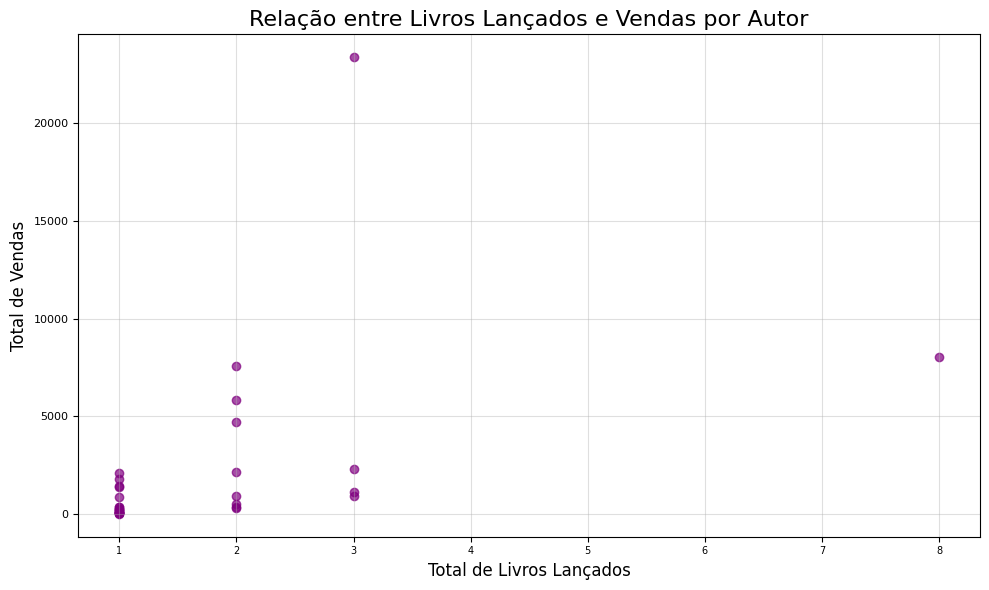

In [21]:
# Contar o número de livros lançados por autor
books_per_author = df.groupby('author_name')['book_id'].nunique().reset_index()
books_per_author = books_per_author.rename(columns={'book_id': 'total_books'})

# Contar o número total de vendas por autor
sales_per_author = df.groupby('author_name')['item_id'].count().reset_index()
sales_per_author = sales_per_author.rename(columns={'item_id': 'total_sales'})

# Merge das tabelas para comparar livros lançados e vendas
author_analysis = pd.merge(books_per_author, sales_per_author, on='author_name')

# Calcular a correlação entre total de livros lançados e vendas
correlation = author_analysis['total_books'].corr(author_analysis['total_sales'])

# Exibir a tabela e a correlação
print(author_analysis.sort_values('total_books', ascending=False))
print(f"Correlação entre número de livros lançados e vendas: {correlation:.2f}")

# Plotar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(author_analysis['total_books'], author_analysis['total_sales'], alpha=0.7, color='purple')
plt.title('Relação entre Livros Lançados e Vendas por Autor', fontsize=16)
plt.xlabel('Total de Livros Lançados', fontsize=12)
plt.ylabel('Total de Vendas', fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()